In [1]:
import sys
from collections import defaultdict
import random
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score, average_precision_score
from copy import deepcopy
from utils import auc, lda_vec
from tqdm import tqdm
from models import KNN
sys.path.append('/root/anaconda3/envs/Python35/lib/python3.5/site-packages')

# Первая часть

In [57]:
fileids = ['danish', 'dutch', 'english', 'finnish', 'french', 'german',
           'greek', 'hungarian', 'italian', 'norwegian', 'portuguese',
           'romanian', 'spanish', 'swedish']
all_stop_words = set(word for fileid in stopwords.fileids() 
                          for word in stopwords.words(fileid))

In [58]:
%%time
f_data = open('data/eurlex_data.txt')
f_labels = open('data/eurlex_labels.txt')
f_clean = open("data/eurlex_data_clean.txt", "w")

id2idx = np.zeros(19941, dtype=int)

documents = []
for i, line in enumerate(f_data.readlines()):
    id_, doc = line.split(', ')
    words = doc[1:-2].split(' ')
    words = [word for word in words if word not in all_stop_words]
    f_clean.write(" ".join(words))
    id_ = int(id_)
    id2idx[id_] = i
    documents.append(words)
    
doc_labels = defaultdict(list)
all_labels = set()
for line in f_labels.readlines():
    label, id_, _ = line.split(' ')
    id_ = int(id_)
    all_labels.add(label)
    doc_labels[id_].append(label)
all_labels = list(all_labels)

CPU times: user 6.68 s, sys: 624 ms, total: 7.31 s
Wall time: 16.6 s


In [59]:
%%time
label_idx = list(doc_labels.keys())
doc_idx = id2idx[np.array(label_idx)]
doc_labels = [[doc_label for doc_label in doc_labels[doc_id]] 
              for doc_id in doc_labels.keys()]
doc2ind = MultiLabelBinarizer(classes=all_labels)
doc_targets = doc2ind.fit_transform(doc_labels)
#doc_targets = doc_targets[:, np.where(doc_targets.sum(axis=0) >= 3)[0]]

CPU times: user 112 ms, sys: 44 ms, total: 156 ms
Wall time: 606 ms


## Разделение train test

In [60]:
size = len(label_idx)
seed = 400
train_size = int(0.9 * size)

np.random.seed(seed)
idx = np.random.permutation(np.arange(size))
train_idx, test_idx = idx[:train_size], idx[train_size:]
y_train, y_test = doc_targets[train_idx, :], doc_targets[test_idx, :]
#documents_labels = deepcopy(documents)
documents = [documents[idx] for idx in doc_idx]
train_docs = [documents[idx] for idx in train_idx]
train_labels = [doc_labels[idx] for idx in train_idx]
test_docs = [documents[idx] for idx in test_idx]
test_labels = [doc_labels[idx] for idx in test_idx]

### TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
%%time
tfidf = TfidfVectorizer().fit_transform([" ".join(doc) for doc in documents])
np.save("doc_vec/tf_idf", tfidf)

CPU times: user 20.4 s, sys: 176 ms, total: 20.5 s
Wall time: 22.3 s


In [8]:
%%time
tfidf = np.load("doc_vec/tf_idf.npy").ravel()[0]
x_train, x_test = tfidf[train_idx, :], tfidf[test_idx, :]

CPU times: user 353 ms, sys: 44 ms, total: 397 ms
Wall time: 396 ms


In [9]:
%%time
n_neighbors = [1, 5, 10, 50, 100]
for neighbor in n_neighbors:
    clf = KNN(metric='cosine', n_neighbors=neighbor)
    clf.fit(x_train, y_train)
    y_pred = clf.predict_proba(x_test)
    print("n_neighbor:\t", neighbor, "\tAUC ROC:\t", auc(roc_auc_score, y_test, y_pred))
    print("n_neighbor:\t", neighbor, "\tAUC PR:\t", auc(average_precision_score, y_test, y_pred))

n_neighbor:	 1 	AUC ROC:	 0.750676575683
n_neighbor:	 1 	AUC PR:	 0.327833351591
n_neighbor:	 5 	AUC ROC:	 0.861396284982
n_neighbor:	 5 	AUC PR:	 0.476843922331
n_neighbor:	 10 	AUC ROC:	 0.893814219128
n_neighbor:	 10 	AUC PR:	 0.496573451825
n_neighbor:	 50 	AUC ROC:	 0.944024704624
n_neighbor:	 50 	AUC PR:	 0.469820825015
n_neighbor:	 100 	AUC ROC:	 0.955518636779
n_neighbor:	 100 	AUC PR:	 0.434961361448
CPU times: user 46.8 s, sys: 516 ms, total: 47.3 s
Wall time: 45.1 s


### word2vec

In [10]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

#### CBOW

In [11]:
%%time
size = 100
model = Word2Vec(documents, window=7, size=size, min_count=1)
model.save("trained_models/w2v_cbow.model")
model = Word2Vec.load("trained_models/w2v_cbow.model")

CPU times: user 4min 55s, sys: 853 ms, total: 4min 56s
Wall time: 1min 54s


In [12]:
%%time
word_vec = lambda x: model[x]
doc_cbow_w2v = np.array([np.array(list(map(word_vec, doc))).mean(axis=0)
                        for doc in documents 
                        ])
np.save("doc_vec/doc_cbow_w2v", doc_cbow_w2v)

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


CPU times: user 3min 1s, sys: 79.8 ms, total: 3min 1s
Wall time: 3min 1s


In [13]:
%%time
doc_cbow_w2v = np.load("doc_vec/doc_cbow_w2v.npy")
x_train, x_test = doc_cbow_w2v[train_idx, :], doc_cbow_w2v[test_idx, :]

CPU times: user 5.31 ms, sys: 6 µs, total: 5.32 ms
Wall time: 5.03 ms


In [14]:
%%time
n_neighbors = [1, 5, 10, 50, 100]
for neighbor in n_neighbors:
    clf = KNN(metric='cosine', n_neighbors=neighbor)
    clf.fit(x_train, y_train)
    y_pred = clf.predict_proba(x_test)
    print("n_neighbor:\t", neighbor, "\tAUC ROC:\t", auc(roc_auc_score, y_test, y_pred))
    print("n_neighbor:\t", neighbor, "\tAUC PR:\t", auc(average_precision_score, y_test, y_pred))

n_neighbor:	 1 	AUC ROC:	 0.720695708916
n_neighbor:	 1 	AUC PR:	 0.274693596933
n_neighbor:	 5 	AUC ROC:	 0.825728057237
n_neighbor:	 5 	AUC PR:	 0.395807710047
n_neighbor:	 10 	AUC ROC:	 0.859909735857
n_neighbor:	 10 	AUC PR:	 0.409605709529
n_neighbor:	 50 	AUC ROC:	 0.921128838999
n_neighbor:	 50 	AUC PR:	 0.380624691252
n_neighbor:	 100 	AUC ROC:	 0.937876639552
n_neighbor:	 100 	AUC PR:	 0.345901337003
CPU times: user 19.5 s, sys: 260 ms, total: 19.8 s
Wall time: 18.4 s


#### Skip-gram

In [15]:
%%time
size = 100
model = Word2Vec(documents, window=7, size=size, min_count=1, sg=1)
model.save("trained_models/w2v_sg.model")
model = Word2Vec.load("trained_models/w2v_sg.model")

CPU times: user 22min 58s, sys: 799 ms, total: 22min 59s
Wall time: 7min 52s


In [16]:
%%time
word_vec = lambda x: model[x]
doc_sg_w2v = np.array([np.array(list(map(word_vec, doc))).mean(axis=0)
                        for doc in documents 
                        ])
np.save("doc_vec/doc_sg_w2v", doc_sg_w2v)

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


CPU times: user 3min 1s, sys: 128 ms, total: 3min 1s
Wall time: 3min 1s


In [17]:
%%time
doc_sg_w2v = np.load("doc_vec/doc_sg_w2v.npy")
x_train, x_test = doc_sg_w2v[train_idx, :], doc_sg_w2v[test_idx, :]

CPU times: user 2.08 ms, sys: 4 ms, total: 6.07 ms
Wall time: 5.8 ms


In [18]:
%%time
n_neighbors = [1, 5, 10, 50, 100]
for neighbor in n_neighbors:
    clf = KNN(metric='cosine', n_neighbors=neighbor)
    clf.fit(x_train, y_train)
    y_pred = clf.predict_proba(x_test)
    print("n_neighbor:\t", neighbor, "\tAUC ROC:\t", auc(roc_auc_score, y_test, y_pred))
    print("n_neighbor:\t", neighbor, "\tAUC PR:\t", auc(average_precision_score, y_test, y_pred))

n_neighbor:	 1 	AUC ROC:	 0.725286429216
n_neighbor:	 1 	AUC PR:	 0.2823371347
n_neighbor:	 5 	AUC ROC:	 0.831376411567
n_neighbor:	 5 	AUC PR:	 0.406965196439
n_neighbor:	 10 	AUC ROC:	 0.867245408569
n_neighbor:	 10 	AUC PR:	 0.424566312992
n_neighbor:	 50 	AUC ROC:	 0.925535226631
n_neighbor:	 50 	AUC PR:	 0.395864167156
n_neighbor:	 100 	AUC ROC:	 0.941851378907
n_neighbor:	 100 	AUC PR:	 0.361389448394
CPU times: user 19.1 s, sys: 284 ms, total: 19.3 s
Wall time: 17.9 s


### doc2vec

In [19]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [20]:
tag_documents_train = [TaggedDocument(doc, tag) 
                       for doc, tag in zip(train_docs, train_labels)]

In [21]:
%%time
size = 100
model = Doc2Vec(tag_documents_train, dm=0, dbow_words=0, vector_size=size, workers=2, min_count=1)
model.save("trained_models/d2v_dbow.model")
model = Doc2Vec.load("trained_models/d2v_dbow.model")

CPU times: user 12min, sys: 700 ms, total: 12min
Wall time: 6min 9s


In [22]:
%%time
random.seed(100)
np.random.seed(100)
doc_dbow_d2v = np.array([model.infer_vector(doc) 
                        for doc in documents])
np.save("doc_vec/doc_dbow_d2v", doc_dbow_d2v)

CPU times: user 2min 13s, sys: 16 ms, total: 2min 13s
Wall time: 2min 13s


In [23]:
%%time
doc_dbow_d2v = np.load("doc_vec/doc_dbow_d2v.npy")
x_train, x_test = doc_dbow_d2v[train_idx, :], doc_dbow_d2v[test_idx, :]

CPU times: user 1.88 ms, sys: 4 ms, total: 5.88 ms
Wall time: 5.46 ms


In [24]:
%%time
n_neighbors = [1, 5, 10, 50, 100]
for neighbor in n_neighbors:
    clf = KNN(metric='cosine', n_neighbors=neighbor)
    clf.fit(x_train, y_train)
    y_pred = clf.predict_proba(x_test)
    print("n_neighbor:\t", neighbor, "\tAUC ROC:\t", auc(roc_auc_score, y_test, y_pred))
    print("n_neighbor:\t", neighbor, "\tAUC PR:\t", auc(average_precision_score, y_test, y_pred))

n_neighbor:	 1 	AUC ROC:	 0.741996120268
n_neighbor:	 1 	AUC PR:	 0.310412519457
n_neighbor:	 5 	AUC ROC:	 0.854518183248
n_neighbor:	 5 	AUC PR:	 0.463817527426
n_neighbor:	 10 	AUC ROC:	 0.886945988956
n_neighbor:	 10 	AUC PR:	 0.478816092001
n_neighbor:	 50 	AUC ROC:	 0.941494309592
n_neighbor:	 50 	AUC PR:	 0.449509277571
n_neighbor:	 100 	AUC ROC:	 0.955031258189
n_neighbor:	 100 	AUC PR:	 0.418509426135
CPU times: user 19.2 s, sys: 228 ms, total: 19.4 s
Wall time: 17.8 s


### LDA

In [6]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary

In [7]:
%%time
from gensim.corpora import Dictionary
dictionary = Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

CPU times: user 24 s, sys: 107 ms, total: 24.1 s
Wall time: 24.1 s


In [8]:
%%time
size = 100
lda = LdaMulticore(corpus, num_topics=size, random_state=100, workers=2)

CPU times: user 39.2 s, sys: 2.04 s, total: 41.2 s
Wall time: 41.6 s


In [28]:
%%time
dictionary = Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]
doc_lda = np.array([lda_vec(corp, lda) 
                    for i, corp in enumerate(corpus)])
np.save("doc_vec/doc_lda", doc_lda)

CPU times: user 1min 11s, sys: 1.52 s, total: 1min 12s
Wall time: 48.3 s


In [29]:
%%time
doc_lda = np.load("doc_vec/doc_lda.npy")
x_train, x_test = doc_lda[train_idx, :], doc_lda[test_idx, :]

CPU times: user 82.9 ms, sys: 8.01 ms, total: 90.9 ms
Wall time: 133 ms


In [30]:
%%time
n_neighbors = [1, 5, 10, 50, 100]
for neighbor in n_neighbors:
    clf = KNN(metric='cosine', n_neighbors=neighbor)
    clf.fit(x_train, y_train)
    y_pred = clf.predict_proba(x_test)
    print("n_neighbor:\t", neighbor, "\tAUC ROC:\t", auc(roc_auc_score, y_test, y_pred))
    print("n_neighbor:\t", neighbor, "\tAUC PR:\t", auc(average_precision_score, y_test, y_pred))

n_neighbor:	 1 	AUC ROC:	 0.579537390282
n_neighbor:	 1 	AUC PR:	 0.0875256234621
n_neighbor:	 5 	AUC ROC:	 0.668851512659
n_neighbor:	 5 	AUC PR:	 0.155109020754
n_neighbor:	 10 	AUC ROC:	 0.713546024103
n_neighbor:	 10 	AUC PR:	 0.175386660971
n_neighbor:	 50 	AUC ROC:	 0.818598402634
n_neighbor:	 50 	AUC PR:	 0.198571750978
n_neighbor:	 100 	AUC ROC:	 0.855491969571
n_neighbor:	 100 	AUC PR:	 0.192476794088
CPU times: user 19.8 s, sys: 292 ms, total: 20.1 s
Wall time: 19 s


### Glove

In [37]:
from glove import Corpus, Glove

In [38]:
%%time
corpus = Corpus()
corpus.fit(documents, window=7)

CPU times: user 37.4 s, sys: 240 ms, total: 37.6 s
Wall time: 37.3 s


In [39]:
%%time
size = 100
model = Glove(no_components=size, random_state=100)
model.fit(corpus.matrix,
         epochs=10,
         no_threads=2,
         verbose=True)
model.add_dictionary(corpus.dictionary)

Performing 10 training epochs with 2 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
CPU times: user 10min 19s, sys: 272 ms, total: 10min 19s
Wall time: 5min 12s


In [40]:
%%time
word_vec = lambda x: model.word_vectors[model.dictionary[x]]
doc_glove = np.array([np.array(list(map(word_vec, doc))).mean(axis=0)
                        for doc in documents 
                        ])
np.save("doc_vec/doc_glove", doc_glove)

CPU times: user 28.8 s, sys: 176 ms, total: 29 s
Wall time: 29 s


In [61]:
%%time
doc_glove = np.load("doc_vec/doc_glove.npy")
x_train, x_test = doc_glove[train_idx, :], doc_glove[test_idx, :]

CPU times: user 6.37 ms, sys: 4 ms, total: 10.4 ms
Wall time: 10.3 ms


In [62]:
%%time
n_neighbors = [1, 5, 10, 50, 100]
for neighbor in n_neighbors:
    clf = KNN(metric='cosine', n_neighbors=neighbor)
    clf.fit(x_train, y_train)
    y_pred = clf.predict_proba(x_test)
    print("n_neighbor:\t", neighbor, "\tAUC ROC:\t", auc(roc_auc_score, y_test, y_pred))
    print("n_neighbor:\t", neighbor, "\tAUC PR:\t", auc(average_precision_score, y_test, y_pred))

n_neighbor:	 1 	AUC ROC:	 0.715543788997
n_neighbor:	 1 	AUC PR:	 0.267849785544
n_neighbor:	 5 	AUC ROC:	 0.821478159689
n_neighbor:	 5 	AUC PR:	 0.388814935573
n_neighbor:	 10 	AUC ROC:	 0.856678341623
n_neighbor:	 10 	AUC PR:	 0.399557520394
n_neighbor:	 50 	AUC ROC:	 0.916750896831
n_neighbor:	 50 	AUC PR:	 0.371976930692
n_neighbor:	 100 	AUC ROC:	 0.934122372933
n_neighbor:	 100 	AUC PR:	 0.339345275446
CPU times: user 20.5 s, sys: 721 ms, total: 21.3 s
Wall time: 20 s


## FastText classification

In [6]:
import fastText

In [58]:
%%time
f_fasttext = open('data/eur_lex_fasttext_train.txt', 'w')
for labels, doc in zip(train_labels, train_docs):
    s = " ".join(doc)
    s += " " + " ".join(map(lambda x: "__label__" + x, labels)) + "\n"
    f_fasttext.write(s)

CPU times: user 646 ms, sys: 120 ms, total: 767 ms
Wall time: 2.11 s


In [59]:
%%time
f_fasttext = open('data/eur_lex_fasttext_test.txt', 'w')
for labels, doc in zip(test_labels, test_docs):
    s = " ".join(doc)
    s += " " + " ".join(map(lambda x: "__label__" + x, labels)) + "\n"
    f_fasttext.write(s)

CPU times: user 61.1 ms, sys: 24.1 ms, total: 85.2 ms
Wall time: 909 ms


In [104]:
%%time
model = fastText.train_supervised("data/eur_lex_fasttext_train.txt", lr=1.5, epoch=100, verbose=2)

CPU times: user 54min 4s, sys: 11.8 s, total: 54min 16s
Wall time: 14min 10s


In [105]:
label, prob = model.predict(" ".join(test_docs[0]), k=len(all_labels))
label2ind = {
    label : i for i, label in enumerate(doc2ind.classes_)
    }

In [106]:
%%time
y_pred = np.zeros((len(test_docs), len(all_labels)))
for i, doc in tqdm(enumerate(test_docs), total=len(test_docs)):
    doc_str = " ".join(doc)
    label, prob = model.predict(doc_str, k=len(all_labels))
    label = list(map(lambda x: x[9:], list(label)))
    for j, l in enumerate(label):
        y_pred[i, label2ind[l]] = prob[j]

100%|██████████| 1932/1932 [00:36<00:00, 53.10it/s]

CPU times: user 36.3 s, sys: 188 ms, total: 36.5 s
Wall time: 36.4 s


In [107]:
print("AUC ROC:\t", auc(roc_auc_score, y_test, y_pred))
print("AUC PR:\t", auc(average_precision_score, y_test, y_pred))

AUC ROC:	 0.976777145935
AUC PR:	 0.56308474537


## Вторая часть

Установить multicore-tsne можно отсюда https://github.com/DmitryUlyanov/Multicore-TSNE

In [9]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [10]:
%%time
cnt_word = Counter([word for doc in documents for word in doc])
most_words = [word for word, _ in cnt_word.most_common(400)]

CPU times: user 4.32 s, sys: 149 ms, total: 4.47 s
Wall time: 4.46 s


In [13]:
%%time
w2v_model = Word2Vec.load("trained_models/w2v_cbow.model")
words_vec = np.array([w2v_model[word] for word in most_words])

CPU times: user 2.29 s, sys: 116 ms, total: 2.4 s
Wall time: 6.35 s


/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [14]:
%%time
tsne = TSNE(n_jobs=4, n_iter=1000)
y = tsne.fit_transform(words_vec)

CPU times: user 5.31 s, sys: 3.1 s, total: 8.41 s
Wall time: 2.59 s


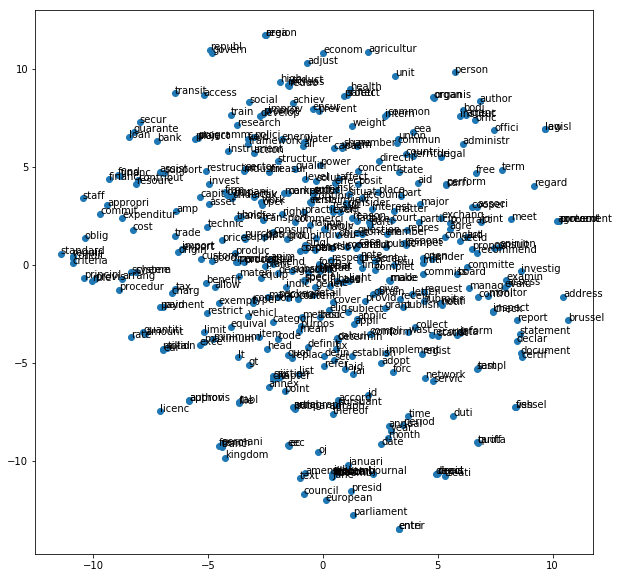

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(y[:, 0], y[:, 1], )
for i, word in enumerate(most_words):
    plt.annotate(word, (y[i, 0], y[i, 1]))
plt.savefig("report/w2v_represent")

### LDAvis

In [32]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

/root/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-05-02 20:36:16.705551. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
%%time
dictionary = Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

CPU times: user 24.2 s, sys: 145 ms, total: 24.3 s
Wall time: 24.3 s


/root/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-05-02 19:49:00.795232. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [26]:
%%time
vis_lda = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/root/anaconda3/envs/Python35/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


CPU times: user 1min, sys: 1.58 s, total: 1min 1s
Wall time: 1min 27s


/root/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-05-02 20:24:30.012299. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [31]:
pyLDAvis.display(vis_lda)

/root/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-05-02 20:36:00.542892. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Третья часть

In [41]:
import pandas as pd

tweet_data = pd.read_csv("data/Sentiment Analysis Dataset.csv", delimiter=',', 
                    error_bad_lines=False, encoding='utf-8')

target = tweet_data['Sentiment']
tweet_data.drop(labels=['ItemID', 'Sentiment', 'SentimentSource'], axis=1, inplace=True)
tweets = list(tweet_data['SentimentText'])
del tweet_data

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [42]:
def del_duplicate(string):
    tmp_ch = string[0]
    res = tmp_ch
    for ch in string[1:]:
        if ch == tmp_ch:
            continue
        else:
            res += ch
            tmp_ch = ch
    if res[0] == ' ':
        return res[1:]
    return res

In [44]:
%%time
tweets = list(map(del_duplicate, tweets))
tweets = [tweet.split(" ") for tweet in tweets]

CPU times: user 17.9 s, sys: 260 ms, total: 18.1 s
Wall time: 18.1 s


### word2vec

In [45]:
from gensim.models import Word2Vec

In [46]:
%%time
size = 100
w2v = Word2Vec(tweets, min_count=1, window=7, size=size, sg=1)
w2v.save("trained_models/tweets_w2v.model")
w2v = Word2Vec.load("trained_models/tweets_w2v.model")

CPU times: user 25min 14s, sys: 7.59 s, total: 25min 22s
Wall time: 18min 33s


In [47]:
%%time
tweets = np.array([np.array([w2v[word] for word in tweet]).mean(axis=0)
                             for tweet in tweets])

/root/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


CPU times: user 3min 24s, sys: 2.09 s, total: 3min 26s
Wall time: 5min 53s


### Разделение на трейн и тест

In [48]:
size = len(target)
seed = 400
train_size = int(0.9 * size)

np.random.seed(seed)
idx = np.random.permutation(np.arange(size))
train_idx, test_idx = idx[:train_size], idx[train_size:]
y_train, y_test = target[train_idx], target[test_idx]
x_train, x_test = tweets[train_idx, :], tweets[test_idx, :]

### Логистическая регрессия

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
%%time
clf = LogisticRegression(verbose=1, n_jobs=-1)
clf.fit(x_train, y_train)

/root/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]CPU times: user 34.2 s, sys: 728 ms, total: 34.9 s
Wall time: 52.9 s


In [54]:
%%time
y_pred = clf.predict_proba(x_test)[:, 1]
print("AUC ROC:\t", roc_auc_score(y_test, y_pred))
print("AUC PR:\t", average_precision_score(y_test, y_pred))
y_pred2 = clf.predict_proba(x_test).argmax(axis=1)
print("Accuracy:\t", (y_pred2 == y_test).mean())

AUC ROC:	 0.847415494009
AUC PR:	 0.845861971079
Accuracy:	 0.767765516717
CPU times: user 814 ms, sys: 36 ms, total: 850 ms
Wall time: 4.57 s


### TF-IDF

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import pandas as pd

tweet_data = pd.read_csv("data/Sentiment Analysis Dataset.csv", delimiter=',', 
                    error_bad_lines=False, encoding='utf-8')

target = tweet_data['Sentiment']
tweet_data.drop(labels=['ItemID', 'Sentiment', 'SentimentSource'], axis=1, inplace=True)
tweets = list(tweet_data['SentimentText'])
del tweet_data

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [4]:
def del_duplicate(string):
    tmp_ch = string[0]
    res = tmp_ch
    for ch in string[1:]:
        if ch == tmp_ch:
            continue
        else:
            res += ch
            tmp_ch = ch
    if res[0] == ' ':
        return res[1:]
    return res

In [5]:
%%time
tweets = list(map(del_duplicate, tweets))

CPU times: user 13.7 s, sys: 35.3 ms, total: 13.7 s
Wall time: 13.7 s


In [6]:
%%time
tfidf = TfidfVectorizer(analyzer='char', 
                        ngram_range=(1, 3), 
                        min_df=0.001, max_features=10000).fit_transform(tweets)

CPU times: user 3min 2s, sys: 2.33 s, total: 3min 4s
Wall time: 3min 41s


In [7]:
size = len(target)
seed = 400
train_size = int(0.9 * size)

np.random.seed(seed)
idx = np.random.permutation(np.arange(size))
train_idx, test_idx = idx[:train_size], idx[train_size:]
y_train, y_test = target[train_idx], target[test_idx]
x_train, x_test = tfidf[train_idx, :], tfidf[test_idx, :]

### Логистическая регрессия

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
%%time
clf = LogisticRegression(verbose=1, n_jobs=2)
clf.fit(x_train, y_train)

/root/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(self.n_jobs))


[LibLinear]CPU times: user 3min 5s, sys: 4.85 s, total: 3min 10s
Wall time: 3min 12s


In [13]:
%%time
y_pred = clf.predict_proba(x_test)
print("AUC ROC:\t", roc_auc_score(y_test, y_pred[:, 1]))
print("AUC PR:\t", average_precision_score(y_test, y_pred[:, 1]))
print("Accuracy:\t", (y_pred.argmax(axis=1) == y_test).mean())

AUC ROC:	 0.86268204925
AUC PR:	 0.863785794068
Accuracy:	 0.781720743434
CPU times: user 558 ms, sys: 24.1 ms, total: 582 ms
Wall time: 5.88 s
